In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import time

from mnist.load_mnist import load_mnist
from STAL.STAL import SpikeThresholdAdaptiveLearning
# from STAL_loss.loss_low_sp import DefaultLoss
from STAL_loss.default_loss import DefaultLoss

device = torch.device("mps")

train_X, train_y, test_X, test_y = load_mnist()

print(train_X[0].shape, train_y[0])

omega = train_X[0].size(0)
psi = 50
c = 1
l1_sz = omega // 2 # 392
l2_sz = omega // 4 # 196
drop_p = 0

STAL = SpikeThresholdAdaptiveLearning(omega, psi, c, l1_sz, l2_sz, drop_p)
STAL.print_learnable_params()

batch_size = 1000
x = test_X[:batch_size]

h, Z1, Z2 = STAL(x)

theta = 0.99
spiketrain = (h > theta).float()
# [batch_size, (window_size * n_channels) * psi]

# Since we have 1 channel, let's squeeze it
B = spiketrain.reshape(batch_size, omega, c, psi).squeeze(2)

b = B[0]
pixels, spikes = np.where(b == 1)

fig, axs = plt.subplots(2, 1, figsize=(8, 6), sharex=True)
axs[0].scatter(pixels, (spikes/psi))
axs[0].set_ylabel("Spikes (time dimension)")
axs[0].set_yticks([])

axs[1].plot(x[0], label="Test sample 0")
axs[1].set_xlabel("Input pixels (spatial dimension)")
axs[1].set_ylabel("Input signal (pixel value)")
axs[1].legend()

plt.suptitle("Spike trains from random initialisation of STAL")
plt.tight_layout()
# plt.savefig("img/random_init_example_mnist.png")
plt.show()

# Loss and Optimizer
default_loss = DefaultLoss()
optimizer = torch.optim.AdamW(STAL.parameters(), lr=0.001)

# Train/Validation
train_X, val_X, train_y, val_y = train_test_split(train_X, train_y, test_size=0.2, random_state=42)
n_epochs = 15

STAL.to(device)

start = time.time()

train_loss = []
val_loss = []
for epoch in range(n_epochs):
    e = []
    for i in range(0, len(train_X), batch_size):
        x_train = train_X[i:i+batch_size].to(device)
        optimizer.zero_grad()
        h, Z1, Z2 = STAL(x_train)
        loss = default_loss(h, x_train, Z1, Z2)
        loss.backward()
        optimizer.step()
        e.append(loss.item())
    train_loss.append(np.mean(e))
    print(f"Epoch {epoch + 1} - Train Loss: {train_loss[-1]:.3f}")
    
    e = []
    with torch.no_grad():
        for i in range(0, len(val_X), batch_size):
            x_val = val_X[i:i+batch_size].to(device)
            h, Z1, Z2 = STAL(x_val)
            loss = default_loss(h, x_val, Z1, Z2)
            e.append(loss.item())
    val_loss.append(np.mean(e))
    print(f"\t- Validation Loss: {val_loss[-1]:.3f}")

# Test
test_loss = []
for i in range(0, len(test_X), batch_size):
    x_test = test_X[:batch_size].to(device)
    h, Z1, Z2 = STAL(x_test)
    loss = default_loss(h, x_test, Z1, Z2)
    test_loss.append(loss.item())
print("---")
print(f"Test Loss: {np.mean(test_loss):.3f}")
print("---")

end = time.time()
print(f"Training took {end-start:.2f}s")

plt.plot(train_loss, label="Train")
plt.plot(val_loss, label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.hlines(np.mean(test_loss), 0, len(train_loss) - 1, colors='black', linestyles='dashed', label="Test")
plt.legend()
plt.tight_layout()
# plt.savefig("img/loss_curves_STAL_mnist")
plt.show()

# Inspect the spike train after training
STAL.cpu()
STAL.eval()

batch_size = 1000
x = test_X[:batch_size]
h, Z1, Z2 = STAL(x)
spiketrain = (h > theta).float()
B = spiketrain.reshape(batch_size, omega, c, psi).squeeze(2)
b = B[0]
pixels, spikes = np.where(b == 1)

fig, axs = plt.subplots(2, 1, figsize=(8, 6), sharex=True)
axs[0].scatter(pixels, (spikes/psi))
axs[0].set_ylabel("Spikes (time dimension)")
axs[0].set_yticks([])

axs[1].plot(x[0], label="Test sample 0")
axs[1].set_xlabel("Input pixels (spatial dimension)")
axs[1].set_ylabel("Input signal (pixel value)")
axs[1].legend()

plt.suptitle("Spike trains after training of STAL")
plt.tight_layout()
# plt.savefig("img/post_training_example_mnist_low_sp.png")
plt.show()



torch.Size([784]) tensor(5)
Total Learnable Parameters (STAL): 425124
Default Loss initialized.
Epoch 1 - Train Loss: 2107.075
	- Validation Loss: 718.493
Epoch 2 - Train Loss: 507.722
	- Validation Loss: 399.888
Epoch 3 - Train Loss: 324.156
	- Validation Loss: 339.941
Epoch 4 - Train Loss: 269.120
	- Validation Loss: 288.803
Epoch 5 - Train Loss: 235.263
	- Validation Loss: 287.762
Epoch 6 - Train Loss: 213.388
	- Validation Loss: 271.626
Epoch 7 - Train Loss: 194.866
	- Validation Loss: 260.270
Epoch 8 - Train Loss: 198.181
	- Validation Loss: 269.847
Epoch 9 - Train Loss: 219.073
	- Validation Loss: 300.798
Epoch 10 - Train Loss: 238.422
	- Validation Loss: 236.706
Epoch 11 - Train Loss: 199.445
	- Validation Loss: 250.612
Epoch 12 - Train Loss: 173.903
	- Validation Loss: 257.564
Epoch 13 - Train Loss: 171.540
	- Validation Loss: 240.798
Epoch 14 - Train Loss: 179.263
	- Validation Loss: 207.127
Epoch 15 - Train Loss: 152.060
	- Validation Loss: 201.159
---
Test Loss: 326.503
---


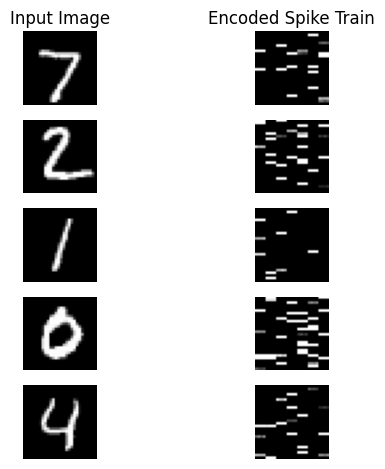

In [32]:
B = spiketrain.reshape(batch_size, omega, c, psi).squeeze(2)

def plot_images(X, B, idx):
    fig, axs = plt.subplots(len(idx), 2)
    if len(idx) == 1:
        axs = [axs]
    
    axs[0, 0].set_title("Input Image")
    axs[0, 1].set_title("Encoded Spike Train")
    for i in idx:
        x = X[i].numpy()
        b = B[i].numpy()
        b_gray = b.mean(axis=1)
        
        axs[i, 0].imshow(x.reshape(28, 28), cmap='gray')

        axs[i, 1].imshow(b_gray.reshape(28, 28), cmap='gray')

    # Remove border
    for ax in axs.flatten():
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.set_yticks([])
        ax.set_xticks([])
    plt.tight_layout()

plot_images(test_X, B, np.arange(5))